# Physics informed relevant information simulation (PIRIS)
**Comparación con el artículo de DFT**


# Librerias y Constantes

In [1]:
#Importamos ls librerias necesarias
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
np.random.seed(10)
tf.random.set_seed(10)

2025-07-24 15:45:30.072665: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753371930.323417      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753371930.395477      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Parametros de creación de la muestra

a = 1.863  #Distancia de enlace Zn-O (A)
beta = 30*np.pi/180 #angulo de proyeccion de los lados del hexágono sobre el eje x en radianes
dist_x = 2*a*np.cos(beta) # distancia entre puntos en el eje x
dist_y = a*np.sin(beta) # distancia entre puntos en el eje y
offset_x = dist_x / 2 #offset de las filas impares a partir de la tercera fila
cols = 6# Número de columnas y filas
rows = 6

# Parametros del potencial L-J
kj_mol_to_ev = 0.01034 #Factor de conversion kj/mol a eV/atomo
SigmaO = 3.71 #Radio de vanderwalls del Oxigeno (A)
EpsilonO = 1.736 * kj_mol_to_ev #Fondo del pozo del Oxigeno (eV/atom)
SigmaNi = 2.834 #Radio de vanderwalls del Niquel (A)
EpsilonNi = 0.0628 *kj_mol_to_ev #Fondo del pozo Niquel (ev/atom)
SigmaZn = 4.045 #Radio de vanderwalls del Zinc (A)
EpsilonZn = 0.23 *kj_mol_to_ev #Fondo del pozo Zinc (ev/atom)
SigmaO_Ni = (SigmaO+SigmaNi)/2 #Constante sigma de interacción cruzada O-Ni 
EpsilonO_Ni = np.sqrt(EpsilonO*EpsilonNi) #Constante epsilon de interacción cruzada O-Ni 
SigmaZn_Ni = (SigmaZn+SigmaNi)/2 #Constante sigma de interacción cruzada Zn-Ni
EpsilonZn_Ni= np.sqrt(EpsilonZn*EpsilonNi) #Constante epsilon de interacción cruzada Zn-Ni 

# Parametros potencial coulomb
k_e = 14.3996 #Constante de coulomb en vacio en (eV A/e^2)
q_Ni = 2 #(carga del electron e)
q_O = -0.86 #(carga del electron e)
q_Zn = 0.86 #(carga del electron e)

# Radios de corte de intereacción basados en el potencial L-J
r_cutoffO_Ni = 2.5*SigmaO_Ni #Radio maximo de interacción Ni-O(A)
r_cutoffZn_Ni = 2.5*SigmaZn_Ni #Radio maximo de interacción Ni-Zn(A)
r_cutoffNi_Ni = 2.5*SigmaNi #Radio maximo de interacción Ni-Ni(A)

In [3]:
# Casteamos a tf los parametros
SigmaO_Ni = tf.cast(SigmaO_Ni, tf.float32)
EpsilonO_Ni = tf.cast(EpsilonO_Ni, tf.float32)
SigmaZn_Ni = tf.cast(SigmaZn_Ni, tf.float32)
EpsilonZn_Ni = tf.cast(EpsilonZn_Ni, tf.float32)
SigmaNi_Ni = tf.cast(SigmaNi, tf.float32)
EpsilonNi_Ni = tf.cast(EpsilonNi, tf.float32)
k_e = tf.cast(k_e,tf.float32)
q_Ni = tf.cast(q_Ni,tf.float32)
q_O = tf.cast(q_O,tf.float32)
q_Zn = tf.cast(q_Zn,tf.float32)
r_cutoffO_Ni = tf.cast(r_cutoffO_Ni, tf.float32)
r_cutoffZn_Ni = tf.cast(r_cutoffZn_Ni, tf.float32)
r_cutoffNi_Ni = tf.cast(r_cutoffNi_Ni, tf.float32)

2025-07-24 15:45:48.991497: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# Creación de la muestra 1: ZnO en forma Grafeno

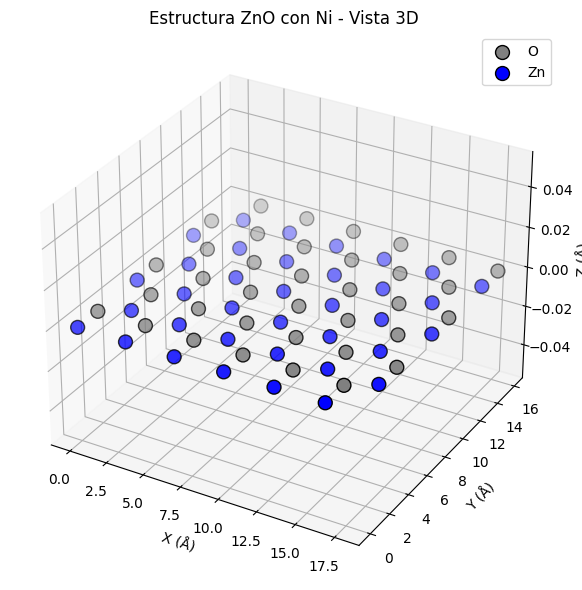

In [4]:
# Generar diccionario de coordenadas
coord_dict = {"Zn": [], "O": []}

for row in range(rows):
    y_zn = row * (a + dist_y)
    y_o = y_zn + a
    x_offset = offset_x if row % 2 == 1 else 0

    for col in range(cols):
        x = col * dist_x + x_offset
        coord_dict["Zn"].append((x, y_zn, 0))
        coord_dict["O"].append((x, y_o, 0))

positions = []
elements = []

for atom_type, coords in coord_dict.items():
    for pos in coords:
        positions.append(pos)
        elements.append(atom_type)



num_atoms = len(positions)
positions = np.array(positions)
elements = np.array(elements)

colors = {"Zn": "blue", "O": "grey"}

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

for atom_type in set(elements):
    idx = [i for i, e in enumerate(elements) if e == atom_type]
    pos = positions[idx]
    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2],
               color=colors.get(atom_type, "black"),
               label=atom_type, s=100, edgecolors='k')

ax.set_xlabel("X (Å)")
ax.set_ylabel("Y (Å)")
ax.set_zlabel("Z (Å)")
ax.set_title("Estructura ZnO con Ni - Vista 3D")
ax.legend()
plt.tight_layout()
plt.show()

# Creación de los iones que se van a adsorber

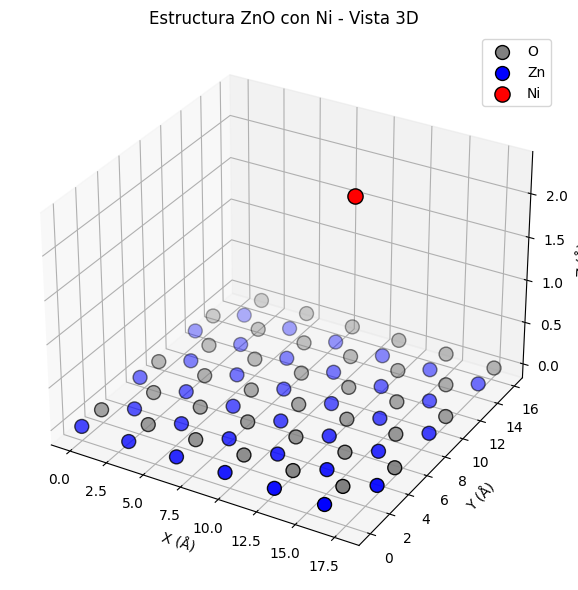

In [5]:
num_ni = 1  # número de iones Ni
z_min, z_max = 0.3 * SigmaO_Ni, 2.0 * SigmaZn_Ni  # altura en Å sobre la monocapa
radius_min, radius_max = 2.0, 5.0  # distancia lateral desde el centro

# Calcular centro de la estructura base
center = np.mean(positions, axis=0)

# Lista para almacenar posiciones de iones Ni
ni_positions = []

while len(ni_positions) < num_ni:
    direction = np.random.normal(size=2)
    direction /= np.linalg.norm(direction)
    r = np.random.uniform(radius_min, radius_max)
    x, y = center[0:2] + r * direction
    z = np.random.uniform(z_min, z_max)
    ni_positions.append([x, y, z])

ni_positions = np.array(ni_positions)


# --- Gráfica 3D Interactiva con Plotly ---
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

for atom_type in set(elements):
    idx = [i for i, e in enumerate(elements) if e == atom_type]
    pos = positions[idx]
    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2],
               color=colors.get(atom_type, "black"),
               label=atom_type, s=100, edgecolors='k')
ax.scatter(ni_positions[:, 0], ni_positions[:, 1], ni_positions[:, 2],
           color='red', label='Ni', s=120, edgecolors='k')

ax.set_xlabel("X (Å)")
ax.set_ylabel("Y (Å)")
ax.set_zlabel("Z (Å)")
ax.set_title("Estructura ZnO con Ni - Vista 3D")
ax.legend()
plt.tight_layout()
plt.show()



# Definición del costo para entrenamiento y evaluación.

**Costo de entrenamiento**

In [6]:
# Lennard-Jones potential function
@tf.function
def physical_potential(r, epsilon, sigma, q_j):
    sr6 = tf.math.pow(sigma / r, 6)
    sr12 = tf.math.pow(sr6, 2)
    lj = 4.0 * epsilon * (sr12 - sr6) + epsilon # Sumamos epsilon para dejar el fondo del pozo en 0
    coulomb = k_e * q_Ni * q_j / tf.maximum(r, 1e-10)
    return lj + coulomb

# Funcion para calcular el potencial de informacion, individual y cruzado
@tf.function
def calculate_cross_information_potential(points1, points2, sigma):
    """
    Calcula el Potencial de Información Cruzado (V) entre dos conjuntos de puntos.
    Si points1 y points2 son el mismo, calcula el Potencial de Información (IP).
    """
    diff = tf.expand_dims(points1, 1) - tf.expand_dims(points2, 0)
    sq_dists = tf.reduce_sum(tf.square(diff), axis=-1)
    kernel_matrix = tf.exp(-sq_dists / (2.0 * sigma**2))
    return tf.reduce_mean(kernel_matrix)
    
# Función de costo para el entrenamiento del modelo
@tf.function
def get_training_loss(positions, elements, ni_positions, pri_weight, lambda_pri, sigma_pri):
     """
    Calcula la energía total de las interacciones entre los iones (ni_positions) y la superficie (positions),
    utilizando un potencial fisico y una regularizacion por PRI.
    Parameters:
        Ni_positions: tensor con posiciones de los iones (num_iones, 3)
        Positions: tensor con posiciones de los átomos de la superficie (num_atoms, 3)
        Elements: tensor con etiquetas de tipo de atomo (num_superficie,)
        pri_weight,lambda_pri,sgma_pri: hiperparametros escalares que modelan el peso de la regulaización
    Returns:
        Energía total del sistema (escalar)
        Energía total de cada ion (num_iones,)
    """
    
    #----------------------INTERACCIONES ION-NANOESTRUCTURA-------
    # Expandir dimensiones para obtener todas las combinaciones de distancias ion-atomo
     pos_exp = tf.expand_dims(positions, axis=1)  # (num_atoms, 1, 3)
     ni_exp = tf.expand_dims(ni_positions, axis=0)  # (1, num_iones, 3)
   
     r = tf.norm(pos_exp - ni_exp, axis=2)  # Uso la norma para calcular la magnitud de la distancia 
                                # entre cada ion y cada átomo de la superficie (num_iones, num_atoms)
     
    # Casteamos las etiquetas para que tengan la forma de r
     elements_exp = tf.reshape(elements, (-1, 1))  # (num_atoms, 1)

    # Creamos una mascara para etiquetar las interacciones
     is_O = tf.equal(elements_exp, "O")
     is_Zn = tf.equal(elements_exp, "Zn")


    # Calculamos la energía aplicando cortes de distancia de interacción
     energy_O = tf.where(r < r_cutoffO_Ni,
                        physical_potential(r, EpsilonO_Ni, SigmaO_Ni,q_O),
                        tf.zeros_like(r))
     energy_Zn = tf.where(r < r_cutoffZn_Ni,
                         physical_potential(r, EpsilonZn_Ni, SigmaZn_Ni, q_Zn),
                         tf.zeros_like(r))
    # Filtramos el valor de la energía dependiendo de la etiqueta
     atoms_energy_matrix = tf.where(is_O, energy_O,
                            tf.where(is_Zn, energy_Zn, tf.zeros_like(r)))
    # Energía total por ion (sumando sobre átomos)
     energy_per_ion = tf.reduce_sum(atoms_energy_matrix, axis=0)  # shape: (num_ions,)

    # --------
    # Esta sección maneja la energía promedio por ion, por ahora no se esta usando
    # Calculamos la energia promedio por ion considerando que no todos interactuan con la misma
    # cantidad de atomos.
    # Definimos mascaras para contar las interacciones validas
     mask_O = tf.cast(tf.less(r, r_cutoffO_Ni), tf.float32) * tf.cast(is_O, tf.float32)
     mask_Zn = tf.cast(tf.less(r, r_cutoffZn_Ni), tf.float32) * tf.cast(is_Zn, tf.float32)
     interaction_mask_atoms = tf.maximum(mask_O, mask_Zn)  # shape: (num_atoms, num_ions)
    # Número de interacciones válidas por ion
     count_per_ion = tf.reduce_sum(interaction_mask_atoms, axis=0)  # shape: (num_ions,)
     count_per_ion_safe = tf.where(count_per_ion == 0, 1.0, count_per_ion)  # evitar división por cero
    # Energia promedio de cada ion
     mean_energy_per_ion = energy_per_ion / count_per_ion_safe  # shape: (num_ions,)
    #---------


    #----------------------INTERACCIONES ION-ION-------
    # Calcula matriz de vectores diferencia entre iones
     diff_ion = tf.expand_dims(ni_positions, 0) - tf.expand_dims(ni_positions, 1)  # (num_ions, num_ions, 3)
    # Calcula matriz de distancias usando norma
     r_ion = tf.norm(diff_ion, axis=-1)  # (num_ions, num_ions)

    # Construye máscaras para excluir la diagonal y aplicar cutoff
     eye = tf.eye(tf.shape(ni_positions)[0], dtype=tf.bool)  # diagonal True
     mask_offdiag = tf.logical_not(eye)  # off-diagonal True
     mask_cutoff = tf.less(r_ion, r_cutoffNi_Ni)  # True si r < cutoff
     interaction_mask_ions = tf.logical_and(mask_offdiag, mask_cutoff)  # pares válidos distintos
    # Prepara distancias válidas evitando divisiones por cero
     valid_r = tf.where(interaction_mask_ions, tf.maximum(r_ion, 1e-10), tf.ones_like(r_ion))

    # Calcula energía Lennard-Jones solo en pares válidos
     ion_energy_matrix = tf.where(interaction_mask_ions,
                             physical_potential(valid_r, EpsilonNi_Ni, SigmaNi_Ni, q_Ni),
                             tf.zeros_like(r_ion))
    # Energías totales ion_ion
     ion_ion_energy_per_ion = tf.reduce_sum(ion_energy_matrix, axis=0)  # (num_ions,)
    
    # --------
    # Esta sección maneja la energía promedio por ion, por ahora no se esta usando
    # Número de interacciones válidas por ion
     count_per_ion_ion = tf.reduce_sum(tf.cast(interaction_mask_ions, tf.float32), axis=0)  # (num_ions,)
     count_per_ion_ion_safe = tf.where(count_per_ion_ion == 0, 1.0, count_per_ion_ion)
    # Energias promedio ion_ion
     mean_ion_ion_energy_per_ion = ion_ion_energy_per_ion / count_per_ion_ion_safe  # (num_ions,)
    #---------------
    
    # calcular la energía total del sistema y la energía por ion
     ion_ion_total_energy = tf.reduce_sum(ion_ion_energy_per_ion) * 0.5 #Multiplico por 0.5 porque la energia aparece una vez para cada ion
     energy_total_per_ion = energy_per_ion + ion_ion_energy_per_ion
     energy_total = tf.reduce_sum(energy_per_ion)+ion_ion_total_energy

    #--------------------REGULARIZACIÓN CON PRI----------------------
    # Analogía: positions -> majority class | ion_positions -> undersampled majority class 

     epsilon_log = 1e-10  # Para estabilidad numérica en el logaritmo

    # Calcular potenciales de información
     ip_ions = calculate_cross_information_potential(ni_positions, ni_positions, sigma_pri)
     ip_surface = calculate_cross_information_potential(positions, positions, sigma_pri) # Es constante, pero se calcula aquí por simplicidad
     cip_ions_surface = calculate_cross_information_potential(ni_positions, positions, sigma_pri)
    # Calcular entropías cuadráticas (H2 = -log(V))
     H2_ions = -tf.math.log(ip_ions + epsilon_log)
     H2_surface = -tf.math.log(ip_surface + epsilon_log)
     H2_cross = -tf.math.log(cip_ions_surface + epsilon_log)

    # Calcular Divergencia de Cauchy-Schwarz (D_cs= 2H2(ion,surface)- H2(ion)- H2(surface)) - Eq. 4 del paper
     D_cs = 2 * H2_cross - H2_ions - H2_surface
    # Calcular costo PRI - Eq. 7 del paper
    # J(X_hat) = H2(X_hat) + lambda * D_cs(X_hat, X)
     pri_cost = (1- lambda_pri)*H2_ions + 2*lambda_pri * D_cs

    #------------COMBINAR Y RETORNAR----------------

     total_loss = (1- pri_weight)*energy_total + pri_weight * pri_cost
    
     return  total_loss, energy_total_per_ion, energy_total, pri_cost

**Costo de evaluación**

In [7]:
@tf.function
def calculate_final_system_energy(positions, elements, ni_positions):
    """
    Calcula la energía del sistema sin PRI y corrige el shift potencial de la energía
    """
    pos_exp = tf.expand_dims(positions, axis=1)
    ni_exp = tf.expand_dims(ni_positions, axis=0)
    r = tf.norm(pos_exp - ni_exp, axis=2)
    elements_exp = tf.reshape(elements, (-1, 1))
    is_O = tf.equal(elements_exp, "O")
    is_Zn = tf.equal(elements_exp, "Zn")
    
    energy_O = tf.where(r < r_cutoffO_Ni, physical_potential(r, EpsilonO_Ni, SigmaO_Ni, q_O), tf.zeros_like(r))
    energy_Zn = tf.where(r < r_cutoffZn_Ni, physical_potential(r, EpsilonZn_Ni, SigmaZn_Ni, q_Zn), tf.zeros_like(r))
    atoms_energy_matrix = tf.where(is_O, energy_O, tf.where(is_Zn, energy_Zn, tf.zeros_like(r)))
    energy_per_ion = tf.reduce_sum(atoms_energy_matrix, axis=0)

    diff_ion = tf.expand_dims(ni_positions, 0) - tf.expand_dims(ni_positions, 1)
    r_ion = tf.norm(diff_ion, axis=-1)
    eye = tf.eye(tf.shape(ni_positions)[0], dtype=tf.bool)
    mask_offdiag = tf.logical_not(eye)
    mask_cutoff = tf.less(r_ion, r_cutoffNi_Ni)
    interaction_mask_ions = tf.logical_and(mask_offdiag, mask_cutoff)
    valid_r = tf.where(interaction_mask_ions, tf.maximum(r_ion, 1e-10), tf.ones_like(r_ion))
    ion_energy_matrix = tf.where(interaction_mask_ions, physical_potential(valid_r, EpsilonNi_Ni, SigmaNi_Ni, q_Ni), tf.zeros_like(r_ion))
    ion_ion_energy_per_ion = tf.reduce_sum(ion_energy_matrix, axis=0)
    
    ion_ion_total_energy = tf.reduce_sum(ion_ion_energy_per_ion) * 0.5
    physical_energy_total = tf.reduce_sum(energy_per_ion) + ion_ion_total_energy
    
    # --- Apply the final epsilon correction ---
    mask_O = tf.cast(tf.less(r, r_cutoffO_Ni), tf.float32) * tf.cast(is_O, tf.float32)
    mask_Zn = tf.cast(tf.less(r, r_cutoffZn_Ni), tf.float32) * tf.cast(is_Zn, tf.float32)
    num_interactions_O = tf.reduce_sum(tf.cast(mask_O, tf.float32))
    num_interactions_Zn = tf.reduce_sum(tf.cast(mask_Zn, tf.float32))
    num_interactions_ionion = tf.reduce_sum(tf.cast(interaction_mask_ions, tf.float32))*0.5 #igual que en la energía, las interacciones se cuentan doble
    total_epsilon_shift = (
        num_interactions_O * EpsilonO_Ni +
        num_interactions_Zn * EpsilonZn_Ni +
        num_interactions_ionion * EpsilonNi_Ni
    )
    corrected_energy_total = physical_energy_total - total_epsilon_shift
    
    return corrected_energy_total, energy_per_ion + ion_ion_energy_per_ion

# Entrenamiento

** Convertir variables a tf**

In [8]:
#tensorflow data
ion = tf.Variable(ni_positions,dtype=tf.float32)
sample_atoms = tf.convert_to_tensor(positions,dtype=tf.float32)
sample_elements = tf.convert_to_tensor(elements, dtype=tf.string)

**Definmos un exponential decay learning rate**

In [9]:
def exp_decay_lr(initial_lr, decay_rate, epoch):
    return initial_lr * decay_rate ** (epoch/5)

**Definimos clase para early stop**

In [10]:
# Callback class
class EarlyStoppingCallback:
    def __init__(self, patience, min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.wait = 0
        self.best_loss = float('inf')
        self.stopped_epoch = 0

    def on_epoch_end(self, epoch, loss):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                return True  # Signal to stop training
        return False  # Continue training

**Loop de entrenamiento**

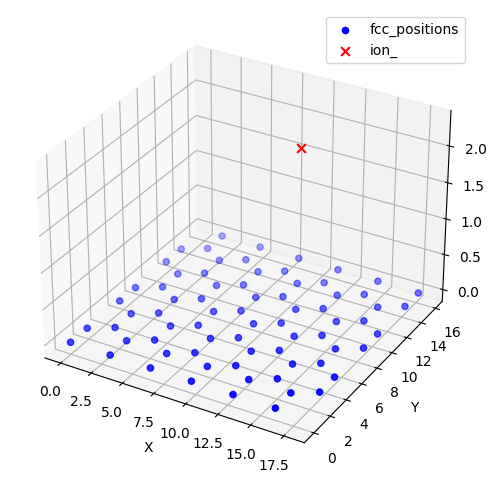

Epoch 1/200
Loss: -1.429184913635254 MeanGrad: [-0.13674416 -0.5537053  -0.7211171 ]
Epoch 2/200
Loss: -0.03609168529510498 MeanGrad: [-0.00459995 -0.69592476 -0.39137307]
Epoch 3/200
Loss: -0.12801751494407654 MeanGrad: [ 0.05893107 -0.66392684 -0.19733723]
Epoch 4/200
Loss: -0.2023228406906128 MeanGrad: [ 0.09407464 -0.6434373  -0.09522921]
Epoch 5/200
Loss: -1.7007172107696533 MeanGrad: [ 0.19213812 -0.49552697  0.01773364]
Epoch 5/200 | Loss: -1.7007 | LR: 0.0960
Epoch 6/200
Loss: -0.2614089846611023 MeanGrad: [ 0.32509956 -0.6106107   0.00076779]
Epoch 7/200
Loss: 1.1035094261169434 MeanGrad: [ 0.18592101 -0.53305125 -0.01774761]
Epoch 8/200
Loss: 1.041434407234192 MeanGrad: [ 0.18073027 -0.53059554  0.01095014]
Epoch 9/200
Loss: 0.9811205863952637 MeanGrad: [ 0.17270112 -0.5287142   0.03577133]
Epoch 10/200
Loss: -0.5176414251327515 MeanGrad: [ 0.1096089  -0.37889698  0.11331657]
Epoch 10/200 | Loss: -0.5176 | LR: 0.0912
Epoch 11/200
Loss: -0.55574631690979 MeanGrad: [ 0.09891312

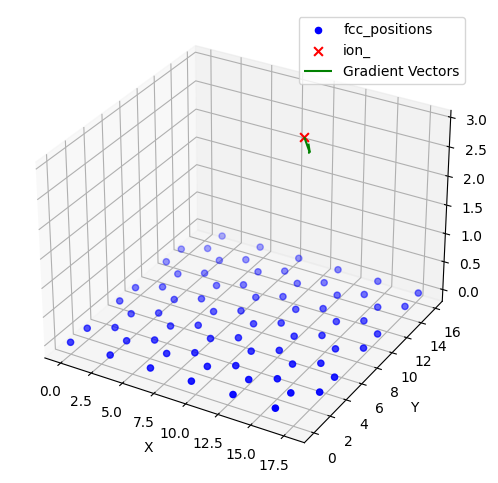

Epoch 16/200
Loss: -2.1765670776367188 MeanGrad: [ 0.03978071 -0.25068527  0.21808386]
Epoch 17/200
Loss: -2.202720880508423 MeanGrad: [ 0.02584206 -0.26056662  0.21532   ]
Epoch 18/200
Loss: -0.7779248952865601 MeanGrad: [-0.1482091 -0.2693539  0.1529303]
Epoch 19/200
Loss: -0.7963842749595642 MeanGrad: [-0.16023396 -0.28299552  0.14501208]
Epoch 20/200
Loss: -0.81764155626297 MeanGrad: [-0.16808143 -0.29799923  0.13608663]
Epoch 20/200 | Loss: -0.8176 | LR: 0.0823
Epoch 21/200
Loss: -0.8417037725448608 MeanGrad: [-0.17191492 -0.31440035  0.12654066]
Epoch 22/200
Loss: -0.8684053421020508 MeanGrad: [-0.17191061 -0.33219534  0.11661623]
Epoch 23/200
Loss: -0.8974815011024475 MeanGrad: [-0.16824687 -0.35134262  0.10644816]
Epoch 24/200
Loss: -0.9286137223243713 MeanGrad: [-0.16111855 -0.37176105  0.09608333]
Epoch 25/200
Loss: -2.475621223449707 MeanGrad: [-0.00442589 -0.49117684  0.14416538]
Epoch 25/200 | Loss: -2.4756 | LR: 0.0782
Epoch 26/200
Loss: -4.038076877593994 MeanGrad: [-0.1

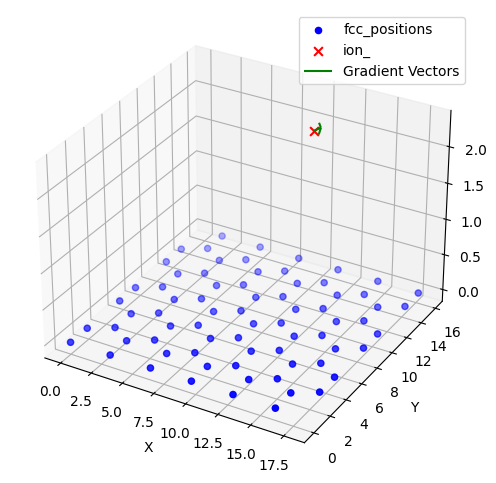

Epoch 31/200
Loss: -2.8006129264831543 MeanGrad: [ 0.09420385 -1.039044    0.02893017]
Epoch 32/200
Loss: -2.8835601806640625 MeanGrad: [ 0.10706063 -1.0469837  -0.00150421]
Epoch 33/200
Loss: -2.9679067134857178 MeanGrad: [ 0.11691947 -1.0428268  -0.03840089]
Epoch 34/200
Loss: -4.484013557434082 MeanGrad: [ 0.22120474 -0.89769036 -0.04096956]
Epoch 35/200
Loss: -4.557258129119873 MeanGrad: [ 0.22060779 -0.8648521  -0.0958662 ]
Epoch 35/200 | Loss: -4.5573 | LR: 0.0706
Epoch 36/200
Loss: -4.6284942626953125 MeanGrad: [ 0.2136937  -0.81891406 -0.15676963]
Epoch 37/200
Loss: -4.696932792663574 MeanGrad: [ 0.19917792 -0.76522154 -0.21795447]
Epoch 38/200
Loss: -6.198155879974365 MeanGrad: [ 0.08806296 -0.5774005  -0.22975403]
Epoch 39/200
Loss: -4.748583793640137 MeanGrad: [ 0.06171678 -0.7086584  -0.3209424 ]
Epoch 40/200
Loss: -4.810338497161865 MeanGrad: [ 0.04034737 -0.6766726  -0.3392608 ]
Epoch 40/200 | Loss: -4.8103 | LR: 0.0670
Epoch 41/200
Loss: -4.871939659118652 MeanGrad: [ 0.

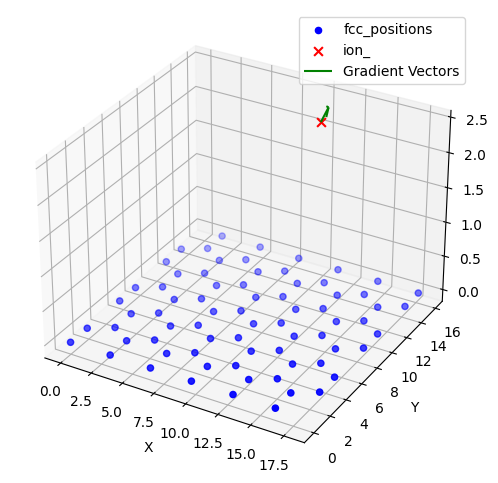

Epoch 46/200
Loss: -5.166527271270752 MeanGrad: [ 0.01436274 -0.7590595  -0.0130551 ]
Epoch 47/200
Loss: -5.220465660095215 MeanGrad: [ 0.01896567 -0.7815115   0.05060605]
Epoch 48/200
Loss: -5.273792266845703 MeanGrad: [ 0.02362203 -0.8011647   0.10286523]
Epoch 49/200
Loss: -5.327493667602539 MeanGrad: [ 0.02824298 -0.81865704  0.1426446 ]
Epoch 50/200
Loss: -6.820732116699219 MeanGrad: [-0.093181   -0.73731947  0.21896681]
Epoch 50/200 | Loss: -6.8207 | LR: 0.0605
Epoch 51/200
Loss: -5.357763290405273 MeanGrad: [ 0.02286891 -0.8898898   0.17197192]
Epoch 52/200
Loss: -6.859297275543213 MeanGrad: [ 0.15051971 -0.80529475  0.22240521]
Epoch 53/200
Loss: -6.84876823425293 MeanGrad: [ 0.01515163 -0.80582947  0.20177361]
Epoch 54/200
Loss: -8.341849327087402 MeanGrad: [ 0.0518515  -0.6720658   0.22543888]
Epoch 55/200
Loss: -8.391057968139648 MeanGrad: [ 0.06022587 -0.6998382   0.18438171]
Epoch 55/200 | Loss: -8.3911 | LR: 0.0575
Epoch 56/200
Loss: -8.441476821899414 MeanGrad: [ 0.07059

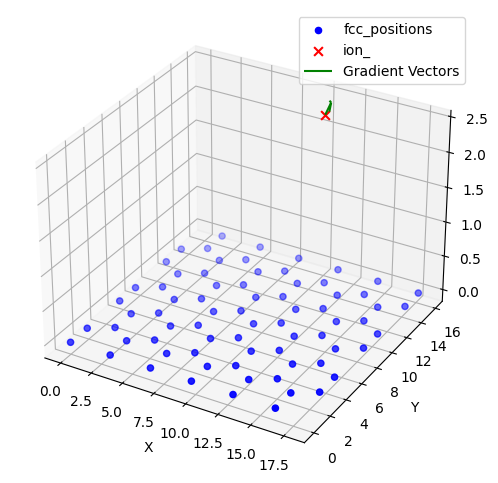

Epoch 61/200
Loss: -8.717877388000488 MeanGrad: [ 0.14880075 -0.9468013  -0.06793544]
Epoch 62/200
Loss: -8.783117294311523 MeanGrad: [ 0.16427298 -0.98770523 -0.03730774]
Epoch 63/200
Loss: -7.349906921386719 MeanGrad: [ 0.3281322  -1.112234   -0.03553091]
Epoch 64/200
Loss: -8.950054168701172 MeanGrad: [ 0.5126469  -1.1094837   0.10107702]
Epoch 65/200
Loss: -9.050801277160645 MeanGrad: [ 0.5243874  -1.1286019   0.19145131]
Epoch 65/200 | Loss: -9.0508 | LR: 0.0519
Epoch 66/200
Loss: -9.159529685974121 MeanGrad: [ 0.53719914 -1.1442957   0.27843666]
Epoch 67/200
Loss: -7.83056640625 MeanGrad: [ 0.40371203 -1.2244521   0.30893475]
Epoch 68/200
Loss: -7.948226451873779 MeanGrad: [ 0.41925928 -1.2393626   0.37460208]
Epoch 69/200
Loss: -8.073468208312988 MeanGrad: [ 0.43817097 -1.2528434   0.42676884]
Epoch 70/200
Loss: -8.206452369689941 MeanGrad: [ 0.46235356 -1.2637379   0.46408486]
Epoch 70/200 | Loss: -8.2065 | LR: 0.0493
Epoch 71/200
Loss: -8.346856117248535 MeanGrad: [ 0.49386597

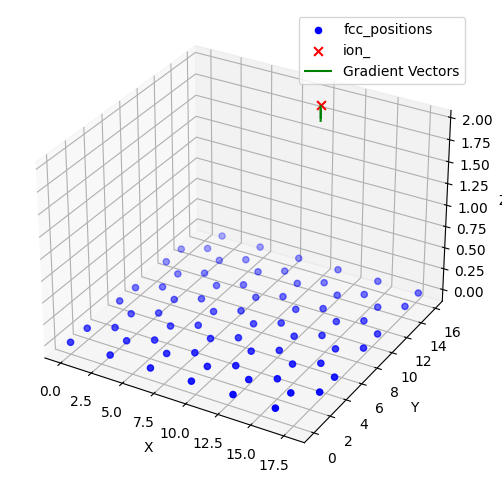

Epoch 76/200
Loss: -7.658447265625 MeanGrad: [ 0.8454103 -1.3317524  0.352488 ]
Epoch 77/200
Loss: -7.8364691734313965 MeanGrad: [ 0.8935441  -1.291511    0.31950942]
Epoch 78/200
Loss: -6.570407867431641 MeanGrad: [ 0.7301629 -1.2770292  0.2436285]
Epoch 79/200
Loss: -6.720590591430664 MeanGrad: [ 0.6306281  -1.2363517   0.17038989]
Epoch 80/200
Loss: -6.767941951751709 MeanGrad: [ 4.5889384e-01 -1.0376395e+00  7.3801912e-04]
Epoch 80/200 | Loss: -6.7679 | LR: 0.0445
Epoch 81/200
Loss: -6.840874195098877 MeanGrad: [-0.05117706 -0.95983374 -0.34253564]
Epoch 82/200
Loss: -6.856165885925293 MeanGrad: [-0.6366769 -1.0385091 -0.9133646]
Epoch 83/200
Loss: -6.846037864685059 MeanGrad: [-1.398606   -0.94043005 -1.4846779 ]
Epoch 84/200
Loss: -6.8785810470581055 MeanGrad: [-1.6803124  -0.91312206 -1.6033249 ]
Epoch 85/200
Loss: -6.968108654022217 MeanGrad: [-1.4699671 -0.9272899 -1.2249744]
Epoch 85/200 | Loss: -6.9681 | LR: 0.0422
Epoch 86/200
Loss: -7.07016134262085 MeanGrad: [-1.0527273  

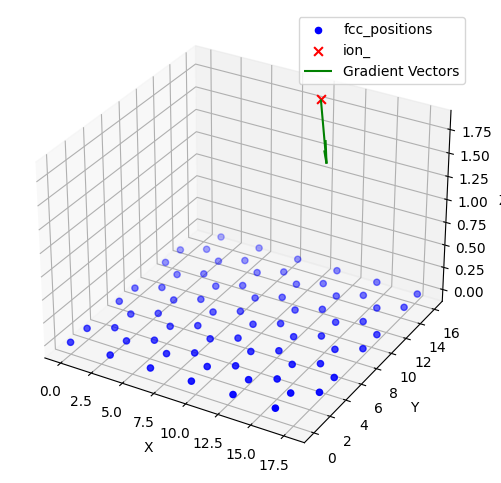

Epoch 91/200
Loss: -5.782014846801758 MeanGrad: [-0.04563717 -0.67899346  0.90190387]
Epoch 92/200
Loss: -5.813357830047607 MeanGrad: [ 0.04772228 -0.6376253   0.9291444 ]
Epoch 93/200
Loss: -5.848185062408447 MeanGrad: [ 0.13310508 -0.60703254  0.9030242 ]
Epoch 94/200
Loss: -5.885382652282715 MeanGrad: [ 0.21716243 -0.58815736  0.8325592 ]
Epoch 95/200
Loss: -5.9231977462768555 MeanGrad: [ 0.30209222 -0.581651    0.7251227 ]
Epoch 95/200 | Loss: -5.9232 | LR: 0.0381
Epoch 96/200
Loss: -7.3993024826049805 MeanGrad: [ 0.5435713  -0.54466033  0.62271   ]
Epoch 97/200
Loss: -7.43355655670166 MeanGrad: [ 0.61006296 -0.5611703   0.46938348]
Epoch 98/200
Loss: -7.466919898986816 MeanGrad: [ 0.64769226 -0.58601904  0.31322038]
Epoch 99/200
Loss: -7.499250888824463 MeanGrad: [ 0.64298207 -0.6154029   0.16724513]
Epoch 100/200
Loss: -7.530308246612549 MeanGrad: [ 0.5859094  -0.64541024  0.04092469]
Epoch 100/200 | Loss: -7.5303 | LR: 0.0362
Epoch 101/200
Loss: -6.117367267608643 MeanGrad: [ 0.

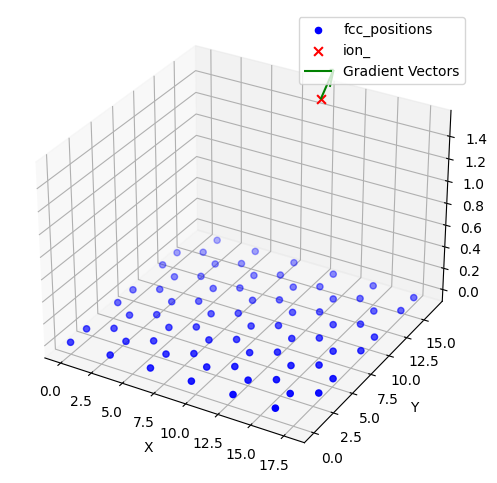

Epoch 106/200
Loss: -7.6564788818359375 MeanGrad: [-0.48583916 -0.680798   -0.15098937]
Epoch 107/200
Loss: -7.674255847930908 MeanGrad: [-0.49934047 -0.6415058  -0.0803387 ]
Epoch 108/200
Loss: -7.692910194396973 MeanGrad: [-0.4698208  -0.59082466  0.00740888]
Epoch 109/200
Loss: -7.71143913269043 MeanGrad: [-0.41093698 -0.5343339   0.09999733]
Epoch 110/200
Loss: -9.169456481933594 MeanGrad: [-0.17893974 -0.42636085  0.2155308 ]
Epoch 110/200 | Loss: -9.1695 | LR: 0.0327
Epoch 111/200
Loss: -10.623286247253418 MeanGrad: [-0.23285659 -0.26995552  0.31366277]
Epoch 112/200
Loss: -10.56275749206543 MeanGrad: [ 0.07564313 -0.26908654  0.35576442]
Epoch 113/200
Loss: -9.062566757202148 MeanGrad: [ 0.02360412 -0.3865434   0.3483591 ]
Epoch 114/200
Loss: -11.951421737670898 MeanGrad: [ 0.07288817 -0.0438014   0.41671702]
Epoch 115/200
Loss: -11.957306861877441 MeanGrad: [ 0.11355589 -0.03854205  0.40761894]
Epoch 115/200 | Loss: -11.9573 | LR: 0.0311
Epoch 116/200
Loss: -11.963529586791992 

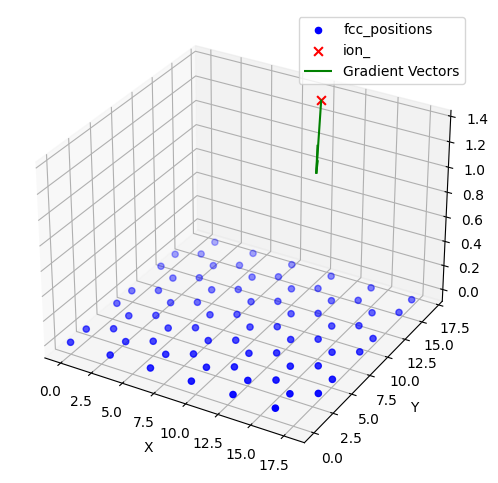

Epoch 121/200
Loss: -11.993781089782715 MeanGrad: [ 0.15674393 -0.18608642  0.13793202]
Epoch 122/200
Loss: -11.998448371887207 MeanGrad: [ 0.12754065 -0.22033814  0.08885275]
Epoch 123/200
Loss: -12.002510070800781 MeanGrad: [ 0.0906636  -0.25142008  0.04597707]
Epoch 124/200
Loss: -12.006047248840332 MeanGrad: [ 0.04920344 -0.277474    0.01110537]
Epoch 125/200
Loss: -12.00918960571289 MeanGrad: [ 0.00685602 -0.29698694 -0.01449269]
Epoch 125/200 | Loss: -12.0092 | LR: 0.0280
Epoch 126/200
Loss: -12.012091636657715 MeanGrad: [-0.0326267  -0.30889764 -0.0301374 ]
Epoch 127/200
Loss: -12.014890670776367 MeanGrad: [-0.06596109 -0.31270906 -0.0358052 ]
Epoch 128/200
Loss: -12.017694473266602 MeanGrad: [-0.09080493 -0.30853423 -0.03213092]
Epoch 129/200
Loss: -12.020541191101074 MeanGrad: [-0.1059917 -0.2971127 -0.0203734]
Epoch 130/200
Loss: -12.023416519165039 MeanGrad: [-0.11151811 -0.27972555 -0.00228941]
Epoch 130/200 | Loss: -12.0234 | LR: 0.0266
Epoch 131/200
Loss: -12.026267051696

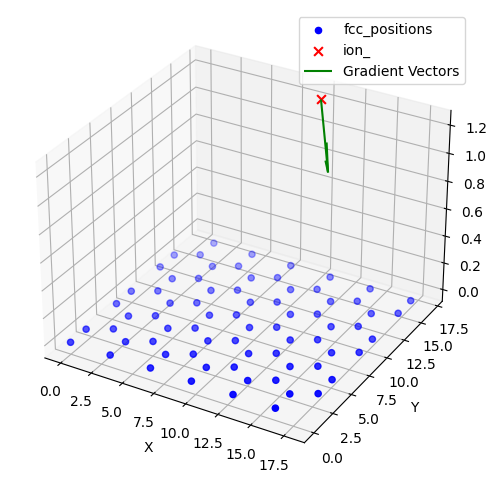

Epoch 136/200
Loss: -12.038330078125 MeanGrad: [-0.02363203 -0.14394262  0.1303278 ]
Epoch 137/200
Loss: -12.040257453918457 MeanGrad: [-0.00455497 -0.12867764  0.14331728]
Epoch 138/200
Loss: -12.042098045349121 MeanGrad: [ 0.01249229 -0.11731561  0.15212844]
Epoch 139/200
Loss: -12.0438871383667 MeanGrad: [ 0.02687281 -0.10986839  0.15688854]
Epoch 140/200
Loss: -12.045653343200684 MeanGrad: [ 0.03817699 -0.10614918  0.15791182]
Epoch 140/200 | Loss: -12.0457 | LR: 0.0240
Epoch 141/200
Loss: -12.047414779663086 MeanGrad: [ 0.04617077 -0.10578915  0.15567805]
Epoch 142/200
Loss: -12.04917049407959 MeanGrad: [ 0.05080439 -0.10833956  0.15072569]
Epoch 143/200
Loss: -12.050919532775879 MeanGrad: [ 0.05216321 -0.11325562  0.14365955]
Epoch 144/200
Loss: -12.052647590637207 MeanGrad: [ 0.05048629 -0.11997802  0.13507468]
Epoch 145/200
Loss: -12.054341316223145 MeanGrad: [ 0.04613865 -0.12791039  0.12557252]
Epoch 145/200 | Loss: -12.0543 | LR: 0.0228
Epoch 146/200
Loss: -12.05598831176757

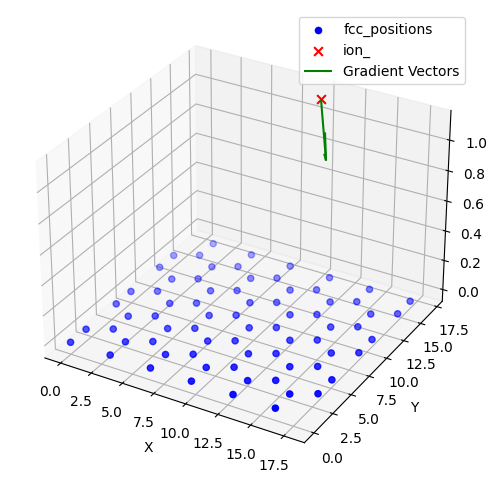

Epoch 151/200
Loss: -12.06336784362793 MeanGrad: [-0.00564308 -0.17197873  0.07605308]
Epoch 152/200
Loss: -12.064701080322266 MeanGrad: [-0.01315095 -0.1752096   0.0719855 ]
Epoch 153/200
Loss: -12.066004753112793 MeanGrad: [-0.01913501 -0.17677514  0.06943825]
Epoch 154/200
Loss: -12.06728458404541 MeanGrad: [-0.02340038 -0.17668551  0.06835987]
Epoch 155/200
Loss: -12.068546295166016 MeanGrad: [-0.02588208 -0.17505856  0.06860992]
Epoch 155/200 | Loss: -12.0685 | LR: 0.0206
Epoch 156/200
Loss: -12.06978988647461 MeanGrad: [-0.02662405 -0.17206232  0.07001274]
Epoch 157/200
Loss: -12.071012496948242 MeanGrad: [-0.02579321 -0.16793054  0.07234511]
Epoch 158/200
Loss: -12.07221508026123 MeanGrad: [-0.02361406 -0.16292994  0.07536409]
Epoch 159/200
Loss: -12.073392868041992 MeanGrad: [-0.02038088 -0.15733007  0.07883214]
Epoch 160/200
Loss: -12.074542999267578 MeanGrad: [-0.01639792 -0.15141107  0.08251366]
Epoch 160/200 | Loss: -12.0745 | LR: 0.0196
Epoch 161/200
Loss: -12.075666427612

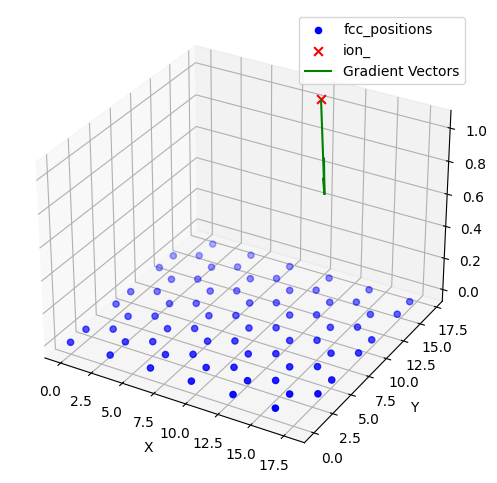

Epoch 166/200
Loss: -12.080886840820312 MeanGrad: [ 0.00768829 -0.12081383  0.09982996]
Epoch 167/200
Loss: -12.081865310668945 MeanGrad: [ 0.00994297 -0.1177187   0.1010626 ]
Epoch 168/200
Loss: -12.082826614379883 MeanGrad: [ 0.01146063 -0.11531857  0.10175723]
Epoch 169/200
Loss: -12.083771705627441 MeanGrad: [ 0.01224749 -0.11357497  0.10195611]
Epoch 170/200
Loss: -12.084702491760254 MeanGrad: [ 0.01234724 -0.11244083  0.10170526]
Epoch 170/200 | Loss: -12.0847 | LR: 0.0177
Epoch 171/200
Loss: -12.085615158081055 MeanGrad: [ 0.011834   -0.11185785  0.10105725]
Epoch 172/200
Loss: -12.086515426635742 MeanGrad: [ 0.01080661 -0.11172713  0.1000931 ]
Epoch 173/200
Loss: -12.087400436401367 MeanGrad: [ 0.00935864 -0.11197581  0.09887385]
Epoch 174/200
Loss: -12.088268280029297 MeanGrad: [ 0.00761803 -0.11250964  0.09747213]
Epoch 175/200
Loss: -12.089118003845215 MeanGrad: [ 0.00569281 -0.11324157  0.09595525]
Epoch 175/200 | Loss: -12.0891 | LR: 0.0168
Epoch 176/200
Loss: -12.08995437

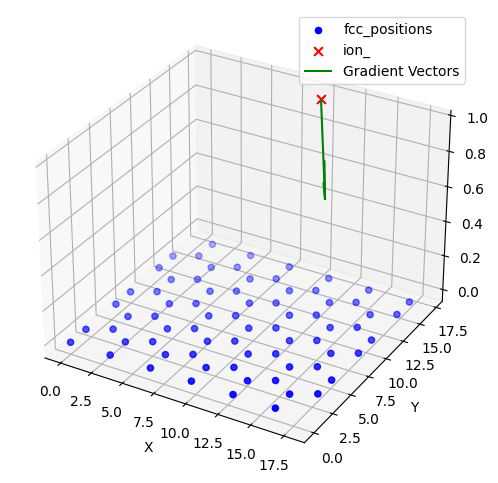

Epoch 181/200
Loss: -12.09390640258789 MeanGrad: [-0.00423396 -0.11738155  0.08760218]
Epoch 182/200
Loss: -12.094653129577637 MeanGrad: [-0.00502049 -0.11751754  0.0866769 ]
Epoch 183/200
Loss: -12.09538745880127 MeanGrad: [-0.0054935  -0.11741732  0.08593044]
Epoch 184/200
Loss: -12.096107482910156 MeanGrad: [-0.00567252 -0.11708533  0.08535671]
Epoch 185/200
Loss: -12.096817016601562 MeanGrad: [-0.005577   -0.11651624  0.08495463]
Epoch 185/200 | Loss: -12.0968 | LR: 0.0151
Epoch 186/200
Loss: -12.097514152526855 MeanGrad: [-0.00523951 -0.11573933  0.0847023 ]
Epoch 187/200
Loss: -12.098200798034668 MeanGrad: [-0.00470614 -0.11475746  0.08459385]
Epoch 188/200
Loss: -12.098871231079102 MeanGrad: [-0.00402698 -0.11361996  0.08459464]
Epoch 189/200
Loss: -12.099533081054688 MeanGrad: [-0.00323499 -0.11232925  0.08470068]
Epoch 190/200
Loss: -12.100183486938477 MeanGrad: [-0.00238717 -0.11093595  0.08487682]
Epoch 190/200 | Loss: -12.1002 | LR: 0.0144
Epoch 191/200
Loss: -12.1008234024

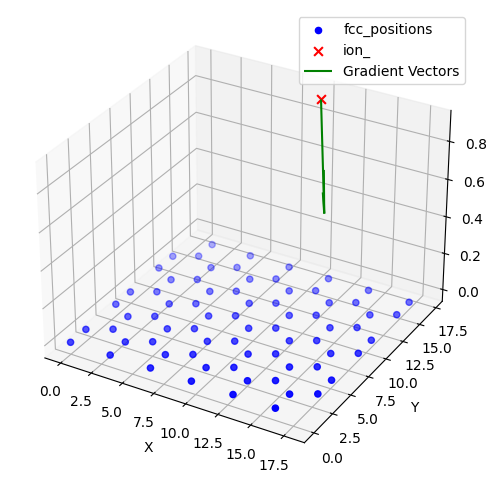

Epoch 196/200
Loss: -12.10385513305664 MeanGrad: [ 0.00179953 -0.10198831  0.08635838]
Epoch 197/200
Loss: -12.10443115234375 MeanGrad: [ 0.00213793 -0.1006243   0.08653153]
Epoch 198/200
Loss: -12.104994773864746 MeanGrad: [ 0.00236107 -0.09933341  0.08666203]
Epoch 199/200
Loss: -12.105552673339844 MeanGrad: [ 0.00246231 -0.09813945  0.08673554]
Epoch 200/200
Loss: -12.106099128723145 MeanGrad: [ 0.00245431 -0.09703165  0.08675925]
Epoch 200/200 | Loss: -12.1061 | LR: 0.0130


In [11]:
ion_ =  ion.numpy()
fig = plt.figure(figsize=(6, 6))  # Adjust figure size if needed
ax = fig.add_subplot(111, projection='3d')

ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='b', s=20, label='fcc_positions')
ax.scatter(ion_[:, 0], ion_[:, 1], ion_[:, 2], c='r', s=40, marker='x', label='ion_')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.show()

# Custom training loop
eta0 = 0.1
epochs = 200
decay_rate = 0.95
optimizer = tf.keras.optimizers.Adam(learning_rate=eta0)
starting_pos =ion_.copy()
loss_history = []#Para guardar y graficar el costo total
pri_history = []#Para guardar y graficar el costo pri
energy_history = []#Para guardar y graficar la energia del sistema

#Hiperparametros de regularización
#posiblemente los ajustemos con optimzación bayesiana
pri_weight = tf.constant(0.5, dtype=tf.float32) #Peso PRI vs Fisica
lambda_pri = tf.constant(0.5, dtype=tf.float32) #Peso Entropia ion-ion vs cruzada
sigma_pri = tf.constant(10, dtype=tf.float32 ) # Ancho del kernel


early_stopping = EarlyStoppingCallback(patience=5, min_delta=0.00001)

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    eta = exp_decay_lr(eta0, decay_rate=decay_rate, epoch=epoch)
    optimizer.learning_rate.assign(eta)
    
    with tf.GradientTape() as g:
        g.watch(ion)
        H_loss,ion_total_energies,energy,pri = get_training_loss(sample_atoms,sample_elements,ion,pri_weight,lambda_pri,sigma_pri)
        loss_history.append(H_loss)
        pri_history.append(pri)
        energy_history.append(energy)
    grad_ = g.gradient(H_loss, ion)
    optimizer.apply_gradients(zip([grad_], [ion]))
    print(f'Loss: {H_loss.numpy()} MeanGrad: {tf.math.reduce_mean(grad_,axis=0).numpy()}')

    # Call the callback's on_epoch_end method
    """if early_stopping.on_epoch_end(epoch, H_loss.numpy()):
        print(f'Early stopping at epoch {early_stopping.stopped_epoch + 1}')
        break"""
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/{epochs} | Loss: {H_loss.numpy():.4f} | LR: {optimizer.learning_rate.numpy():.4f}')
    ion_ =  ion.numpy()
    gradN = -10*eta*grad_.numpy()
    # For quiver, we need to create a 3D representation of the gradient
    # Assuming gradN is a 2D array (num_ions, 2)
    gradN_3D = np.zeros(gradN.shape,dtype=gradN.dtype)  # Initialize with zeros for z-component
    gradN_3D = gradN  # Copy x and y components from gradN
    if (epoch+1)%15==0:
    
    
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, projection='3d')
    
        ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='b', s=20, label='fcc_positions')
        ax.scatter(ion_[:, 0], ion_[:, 1], ion_[:, 2], c='r', s=40, marker='x', label='ion_')
    
        
    
        ax.quiver(ion_[:, 0], ion_[:, 1], ion_[:, 2], gradN_3D[:, 0], gradN_3D[:, 1], gradN_3D[:, 2],
                  color='g', length=1, normalize=True, label='Gradient Vectors')  # Adjust length and normalize as needed
    
        #ax.set_xlim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])
        #ax.set_ylim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])
        #ax.set_zlim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])
    
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.legend()
    
        plt.show()


# Evaluacion de la energía final

In [12]:
#Calculamos la energía al final del entrenamiento y corregimos el desplazamiento del epsilon
final_energy,_= calculate_final_system_energy(
    sample_atoms,  # Tensor con TODAS las posiciones de átomos de la superficie (Zn + O)
    sample_elements,   # Tensor con las etiquetas correspondientes
    ion
    )
    
# Pasa a numpy para reportes
system_energy = final_energy.numpy()

In [13]:
print(f'Atomos en la superficie: {num_atoms} - Iones a adsorber: {num_ni}')
print(f'Energía total del sistema:{system_energy:.5f} ev/atom')
print(f'Energía promedio de adsorcion por ion:{system_energy/num_ni:.5f} ev/atom')
print(f"Desviación estándar de energía por ion: {tf.math.reduce_std(ion_total_energies):.5f} ev/atom") #Revisar
distance = ion_ - starting_pos
mean_vector = np.mean(distance, axis=0)  # Promedio en X, Y, Z
mean_magnitude = np.mean(np.linalg.norm(distance, axis=1))
print(f'Distancia viajada promedio (vectorial): {mean_vector}')
print(f'Distancia promedio recorrida (magnitud): {mean_magnitude:.3f} Å')

Atomos en la superficie: 72 - Iones a adsorber: 1
Energía total del sistema:-25.01857 ev/atom
Energía promedio de adsorcion por ion:-25.01857 ev/atom
Desviación estándar de energía por ion: 0.00000 ev/atom
Distancia viajada promedio (vectorial): [-2.272972   7.675233  -1.4302347]
Distancia promedio recorrida (magnitud): 8.131 Å


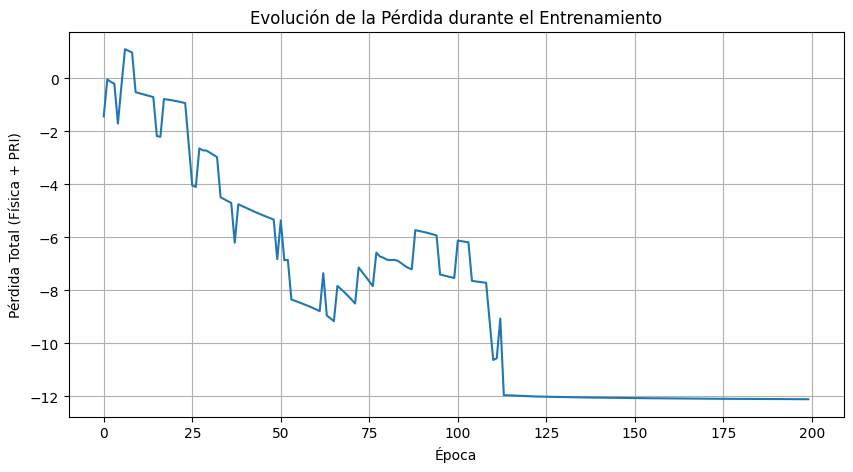

In [14]:
# --- Gráfica de la evolución de la pérdida ---
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.xlabel("Época")
plt.ylabel("Pérdida Total (Física + PRI)")
plt.title("Evolución de la Pérdida durante el Entrenamiento")
plt.grid(True)
plt.show()

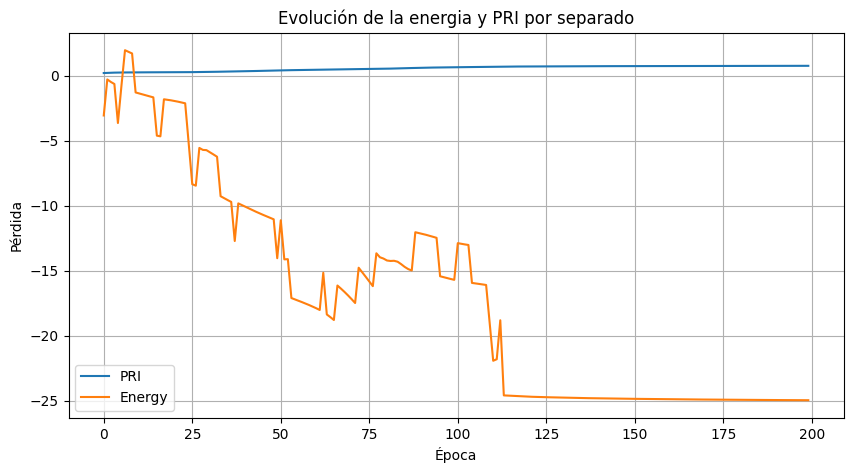

In [15]:
# --- Gráfica de la evolución de la energia y el costo pri ---
plt.figure(figsize=(10, 5))
plt.plot(pri_history,label="PRI")
plt.plot(energy_history, label="Energy")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Evolución de la energia y PRI por separado")
plt.grid(True)
plt.legend()
plt.show()

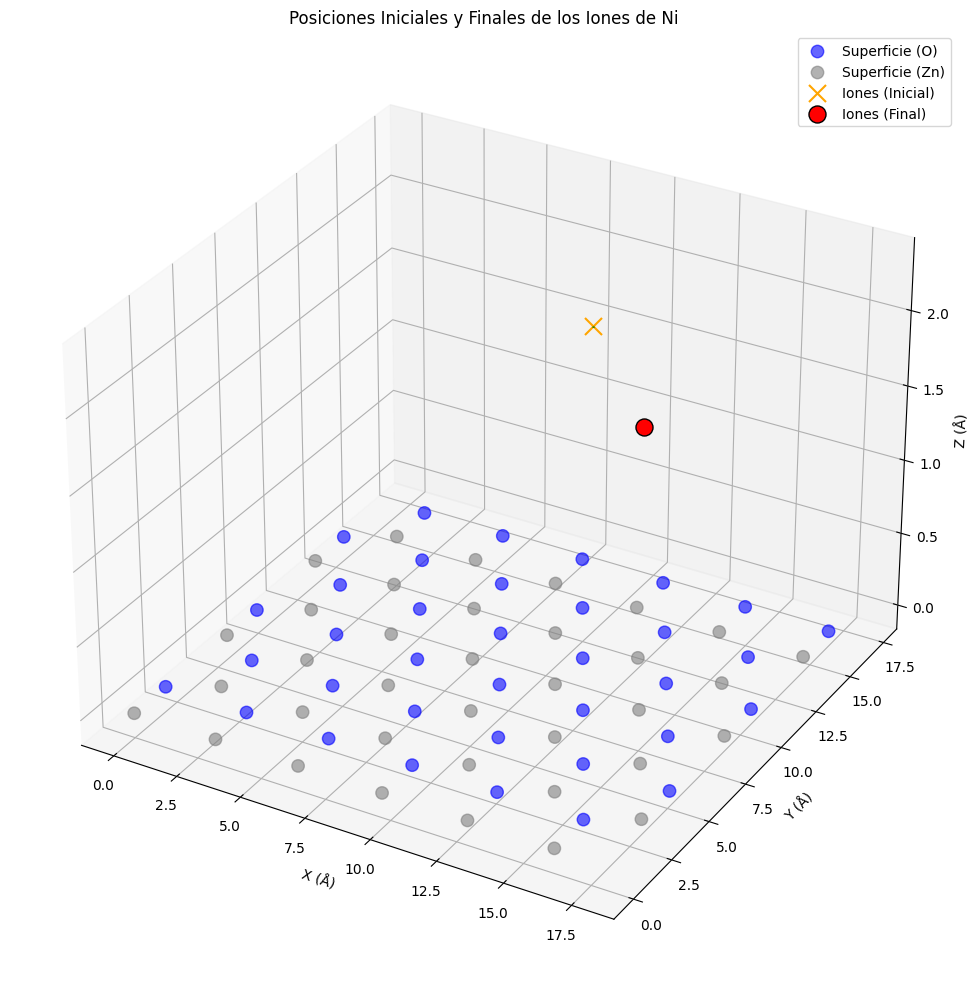

In [16]:
# --- Gráfica 3D de posiciones iniciales y finales ---
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Superficie
colors_map = {"Zn": "grey", "O": "blue"}
for atom_type in set(elements):
    idx = (elements == atom_type)
    ax.scatter(positions[idx, 0], positions[idx, 1], positions[idx, 2],
               color=colors_map.get(atom_type, "black"),
               label=f'Superficie ({atom_type})', s=80, alpha=0.6)

# Posiciones de los iones
ax.scatter(starting_pos[:, 0], starting_pos[:, 1], starting_pos[:, 2],
           color='orange', label='Iones (Inicial)', s=150, marker='x')
ax.scatter(ion_[:, 0], ion_[:, 1], ion_[:, 2],
           color='red', label='Iones (Final)', s=150, edgecolors='k')

# Flechas de trayectoria
for i in range(num_ni):
    ax.quiver(starting_pos[i, 0], starting_pos[i, 1], starting_pos[i, 2],
              gradN_3D[i, 0], gradN_3D[i, 1], gradN_3D[i, 2],
              color='green', arrow_length_ratio=0.3, alpha=0.7)

ax.set_xlabel("X (Å)")
ax.set_ylabel("Y (Å)")
ax.set_zlabel("Z (Å)")
ax.set_title("Posiciones Iniciales y Finales de los Iones de Ni")
ax.legend()
plt.tight_layout()
plt.show()